In [2]:
import matplotlib
print(matplotlib.get_cachedir())

C:\Users\hyeon\.matplotlib


데이터 기간: 2022-01-01 00:00:00 ~ 2025-07-01 00:00:00
총 품목 수: 100개
--------------------------------------------------


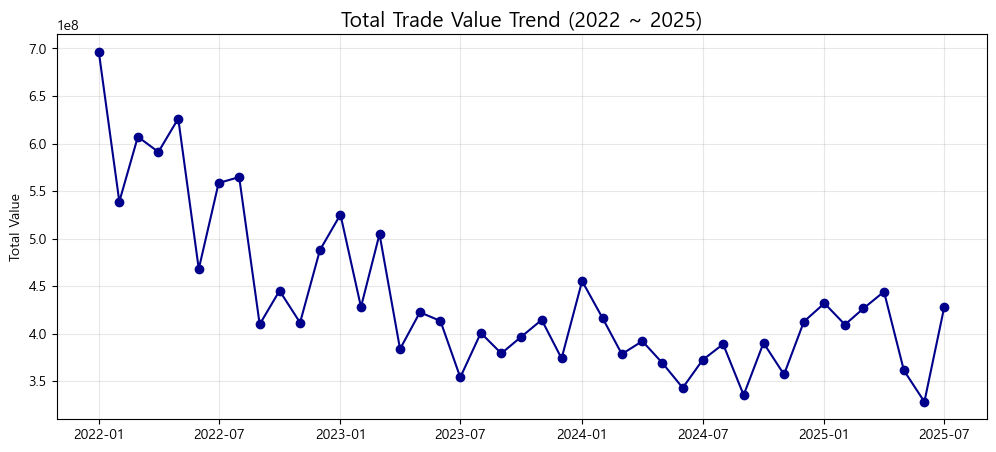


>>> [거래 규모 상위 5개 품목] (시장을 주도하는 품목)
            Mean_Value        CV
item_id                         
FCYBOAXC  1.086511e+08  0.074651
ATLDMDBO  5.999737e+07  0.545526
GYHKIVQT  3.387814e+07  0.398410
CCLHWFWF  2.516274e+07  0.448542
STZDBITS  2.459549e+07  0.424595

>>> [변동성 상위 5개 품목] (예측 난이도 높음)
            Mean_Value        CV
item_id                         
KFQSHBNH  1.129436e+06  2.575247
RJCAXSGH  7.164606e+05  2.312124
OGAFEHLU  1.785497e+06  1.903811
VWMBASNE  4.570423e+05  1.413497
BSRMSVTC  5.216824e+05  1.113147


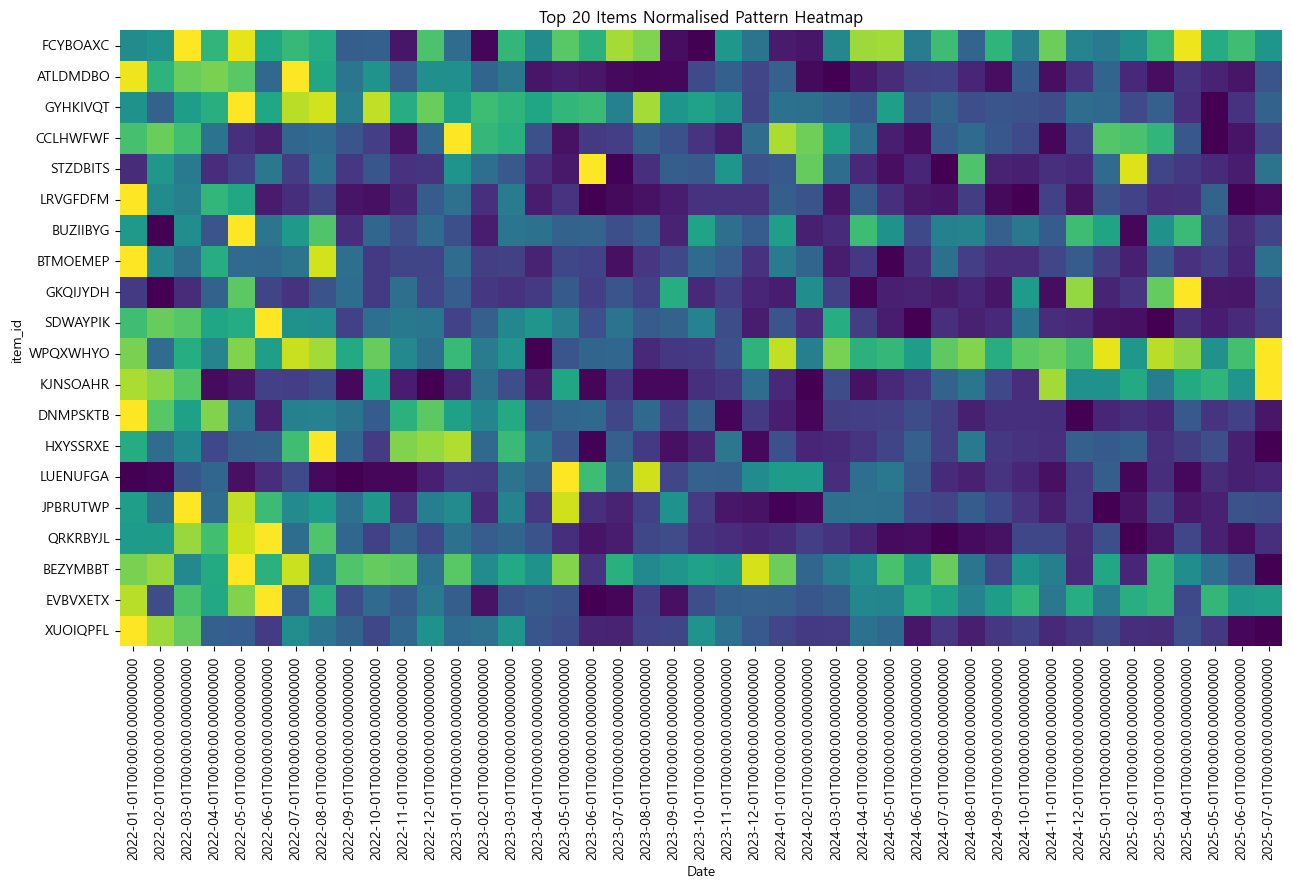

In [5]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import platform

# 운영체제에 따른 한글 폰트 설정
if platform.system() == 'Windows':
    # 윈도우의 경우 '맑은 고딕'
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':
    # Mac의 경우 'AppleGothic'
    plt.rcParams['font.family'] = 'AppleGothic'

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터 로드 및 전처리
DATA_PATH = '../data'
train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))

# 날짜 컬럼 생성
train['date'] = pd.to_datetime(train['year'].astype(str) + '-' + 
                               train['month'].astype(str) + '-01')

# 월별/품목별 집계 (핵심 단계)
df_agg = train.groupby(['date', 'item_id'])['value'].sum().reset_index()
pivot_df = df_agg.pivot(index='date', columns='item_id', values='value').fillna(0)

print(f"데이터 기간: {pivot_df.index.min()} ~ {pivot_df.index.max()}")
print(f"총 품목 수: {pivot_df.shape[1]}개")
print("-" * 50)

# -------------------------------------------------------------------------
# 1. 전체 시장 추세 분석 (Macro Trend)
# -------------------------------------------------------------------------
# 모든 품목의 무역량을 합쳐서 전체 시장이 어떻게 움직이는지 봅니다.
total_volume = pivot_df.sum(axis=1)

plt.figure(figsize=(12, 5))
plt.plot(total_volume.index, total_volume.values, marker='o', color='darkblue')
plt.title('Total Trade Value Trend (2022 ~ 2025)', fontsize=15)
plt.grid(True, alpha=0.3)
plt.ylabel('Total Value')
plt.show()

# 인사이트: 전체 시장이 우상향인지, 특정 계절(예: 연말)에 튀는지 확인

# -------------------------------------------------------------------------
# 2. 변화량 및 변동성 분석 (Volatility Analysis)
# -------------------------------------------------------------------------
# 전월 대비 증감율(%) 계산
pct_change_df = pivot_df.pct_change()

# 품목별 변동성 지표 계산 (CV: 변동계수 = 표준편차 / 평균)
# 단순히 표준편차만 보면 거래량이 큰 품목이 변동성도 커 보이므로,
# 거래 규모 대비 얼마나 흔들리는지를 보기 위해 CV를 씁니다.
item_stats = pd.DataFrame()
item_stats['Mean_Value'] = pivot_df.mean()
item_stats['Std_Dev'] = pivot_df.std()
item_stats['CV'] = item_stats['Std_Dev'] / item_stats['Mean_Value'] # 변동계수
item_stats['Zero_Count'] = (pivot_df == 0).sum() # 거래 없는 달의 수

# -------------------------------------------------------------------------
# 3. 주요 품목 통계 (Top Items)
# -------------------------------------------------------------------------
# 거래 규모(Mean Value) 상위 5개 품목
top_volume_items = item_stats.sort_values(by='Mean_Value', ascending=False).head(5)

print("\n>>> [거래 규모 상위 5개 품목] (시장을 주도하는 품목)")
print(top_volume_items[['Mean_Value', 'CV']])

# 변동성(CV) 상위 5개 품목 (예측이 가장 어려운 품목들)
# 단, 너무 거래가 적은 품목은 제외하고 봄 (평균 거래량 상위 50% 중에서)
median_val = item_stats['Mean_Value'].median()
top_volatile_items = item_stats[item_stats['Mean_Value'] > median_val].sort_values(by='CV', ascending=False).head(5)

print("\n>>> [변동성 상위 5개 품목] (예측 난이도 높음)")
print(top_volatile_items[['Mean_Value', 'CV']])

# -------------------------------------------------------------------------
# 4. 히트맵 시각화 (패턴 한눈에 보기)
# -------------------------------------------------------------------------
# 상위 20개 품목에 대해서만 히트맵을 그려서 패턴 확인
top_20_items = item_stats.sort_values(by='Mean_Value', ascending=False).head(20).index
subset_df = pivot_df[top_20_items]

# 정규화 (Min-Max Scaling) 하여 패턴만 비교
# (값의 크기가 다르면 색깔로 비교가 안되므로 0~1로 맞춤)
subset_norm = (subset_df - subset_df.min()) / (subset_df.max() - subset_df.min())

plt.figure(figsize=(15, 8))
sns.heatmap(subset_norm.T, cmap='viridis', cbar=False) # x축: 시간, y축: 품목
plt.title('Top 20 Items Normalised Pattern Heatmap')
plt.xlabel('Date')
plt.show()

In [6]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import os

# 1. 데이터 준비 (이전 단계의 pivot_df가 있다고 가정)
# 만약 없다면 다시 로드
if 'pivot_df' not in locals():
    # (코드 생략: 위에서 로드한 pivot_df 사용)
    pass

# 2. 결과 저장을 위한 딕셔너리
final_prediction_map = {}
strategy_log = [] # 어떤 품목이 어떤 전략을 썼는지 기록

# -------------------------------------------------------------------------
# 전략 1: 공행성(Lead-Lag) 모델 적용 (가장 우선순위 높음)
# -------------------------------------------------------------------------
# pairs_df는 이전 단계에서 구한 상위 상관관계 쌍 (Threshold > 0.6)
# pairs_df가 정의되어 있어야 합니다.
predicted_items = set()

if 'pairs_df' in locals() and not pairs_df.empty:
    model_lr = LinearRegression()
    
    for idx, row in pairs_df.iterrows():
        leader = row['Leader (선행)']
        follower = row['Follower (후행)']
        
        # 이미 예측한 품목이면 패스 (중복 방지)
        if follower in predicted_items: continue
        
        # 학습 데이터 준비
        data = pd.DataFrame({
            'X': pivot_df[leader].shift(1),
            'y': pivot_df[follower]
        }).dropna()
        
        if len(data) < 3: continue
        
        # 학습 및 예측
        model_lr.fit(data[['X']], data['y'])
        last_leader_val = pivot_df[leader].iloc[-1]
        pred_val = model_lr.predict([[last_leader_val]])[0]
        
        # 결과 저장
        final_prediction_map[follower] = max(0, pred_val) # 음수 방지
        predicted_items.add(follower)
        strategy_log.append({'item_id': follower, 'strategy': 'Lead-Lag Model'})

print(f">>> 전략 1 (Lead-Lag) 적용 완료: {len(predicted_items)}개 품목")


# -------------------------------------------------------------------------
# 전략 2 & 3: 나머지 품목 처리 (안정적 vs 불안정적)
# -------------------------------------------------------------------------
# 남은 품목들
remaining_items = [col for col in pivot_df.columns if col not in predicted_items]

for item in remaining_items:
    series = pivot_df[item]
    
    # 최근 6개월 데이터
    recent_series = series.iloc[-6:]
    
    # 0이 너무 많은 경우 (희소 데이터) -> 그냥 마지막 값 유지 or 0
    if (recent_series == 0).sum() >= 4:
        pred_val = series.iloc[-1] # Naive Forecast
        strategy_name = 'Naive (Sparse)'
        
    else:
        # 변동성(CV) 체크
        mean_val = recent_series.mean()
        std_val = recent_series.std()
        cv = std_val / (mean_val + 1e-9)
        
        if cv < 0.5: 
            # 전략 2: 안정적인 품목 -> 지수 이동 평균 (최근 값에 가중치)
            # pandas의 ewm(Exponential Weighted Moving average) 사용
            pred_val = series.ewm(span=3).mean().iloc[-1]
            strategy_name = 'Exponential Smoothing (Stable)'
        else:
            # 전략 3: 변동성이 큰 나머지 -> 최근 3개월 단순 평균
            pred_val = recent_series.iloc[-3:].mean()
            strategy_name = 'Moving Avg (Volatile)'

    final_prediction_map[item] = max(0, pred_val)
    strategy_log.append({'item_id': item, 'strategy': strategy_name})

print(f">>> 전략 2,3 (Smoothing/Avg) 적용 완료: {len(remaining_items)}개 품목")


# -------------------------------------------------------------------------
# 3. 제출 파일 생성
# -------------------------------------------------------------------------
# submission 로드
sub_path = os.path.join(DATA_PATH, 'sample_submission.csv')
submission = pd.read_csv(sub_path)

# item_id 컬럼 찾기 (보통 두 번째 컬럼이 item_id)
# 사용자의 데이터 형태: [ID, item_id, value] 추정
if 'item_id' in submission.columns:
    id_col = 'item_id'
else:
    id_col = submission.columns[1] 

target_col = submission.columns[-1] # 마지막 컬럼이 예측값 들어갈 자리

# 매핑 및 결측치 처리 (혹시 모를 누락 대비 0 채움)
submission[target_col] = submission[id_col].map(final_prediction_map).fillna(0)

# 저장
save_path = os.path.join(DATA_PATH, 'hybrid_submission.csv')
submission.to_csv(save_path, index=False)

# 로그 확인 (어떤 품목이 어떤 전략을 썼나?)
log_df = pd.DataFrame(strategy_log)
print("\n>>> 전략별 적용 품목 수:")
print(log_df['strategy'].value_counts())

print(f"\n>>> 최종 파일 저장 완료: {save_path}")

>>> 전략 1 (Lead-Lag) 적용 완료: 0개 품목
>>> 전략 2,3 (Smoothing/Avg) 적용 완료: 100개 품목

>>> 전략별 적용 품목 수:
strategy
Moving Avg (Volatile)             45
Exponential Smoothing (Stable)    45
Naive (Sparse)                    10
Name: count, dtype: int64

>>> 최종 파일 저장 완료: ../data\hybrid_submission.csv


Input Shape: torch.Size([40, 3, 1])
Target Shape: torch.Size([40, 1])

>>> PyTorch LSTM 학습 시작...
Epoch [50/200], Loss: 0.066607
Epoch [100/200], Loss: 0.064120
Epoch [150/200], Loss: 0.063711
Epoch [200/200], Loss: 0.063322


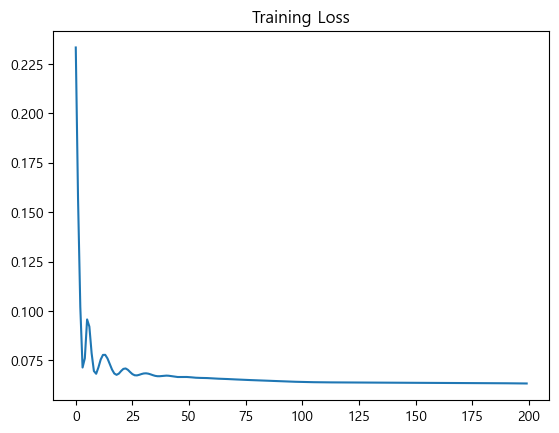

--------------------------------------------------
품목 ID: FCYBOAXC
2025년 8월 예측 무역량 (LSTM): 108,162,472.00
--------------------------------------------------


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. 데이터 준비 (이전 단계의 pivot_df가 있다고 가정)
# ---------------------------------------------------------
# pivot_df가 없다면 이전 단계 코드를 실행하거나, 아래 더미 데이터를 주석 해제해서 테스트하세요.
# pivot_df = pd.DataFrame(...) 

target_item = 'FCYBOAXC'

# 데이터가 없으면 에러 방지를 위해 예외처리
if 'pivot_df' in locals() and target_item in pivot_df.columns:
    series = pivot_df[target_item].values.reshape(-1, 1)
else:
    print(f"'{target_item}' 데이터가 없어 임시 데이터로 진행합니다.")
    series = np.arange(100).reshape(-1, 1) + np.random.randn(100, 1) * 5

# 정규화 (MinMax Scaling: 0~1 사이로 변환)
# 딥러닝은 데이터 스케일에 민감하므로 필수입니다.
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series)

# 시계열 데이터셋 생성 함수 (Sliding Window)
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 3  # 과거 3개월을 보고 다음달 예측
X, y = create_sequences(series_scaled, SEQ_LENGTH)

# Tensor로 변환 (PyTorch는 Tensor를 입력으로 받음)
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y)

print(f"Input Shape: {X_tensor.shape}") # (Batch_Size, Sequence_Length, Input_Size)
print(f"Target Shape: {y_tensor.shape}")


# ---------------------------------------------------------
# 2. LSTM 모델 정의 (nn.Module 상속)
# ---------------------------------------------------------
class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # batch_first=True: 입력 데이터가 (Batch, Seq, Feature) 순서임을 명시
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # 마지막 결과를 예측값으로 변환하는 선형 레이어
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # h0, c0는 설정 안 하면 자동으로 0으로 초기화됨
        # LSTM 출력: (out, (hidden_state, cell_state))
        out, _ = self.lstm(x)
        
        # out의 shape: (Batch, Seq, Hidden)
        # 우리는 마지막 타임스텝의 결과만 필요함 -> out[:, -1, :]
        last_time_step_out = out[:, -1, :]
        
        prediction = self.fc(last_time_step_out)
        return prediction

# 하이퍼파라미터 설정
INPUT_SIZE = 1    # feature 개수 (무역량 1개)
HIDDEN_SIZE = 50  # 은닉 노드 수
OUTPUT_SIZE = 1   # 예측할 값 개수 (다음달 무역량 1개)
LEARNING_RATE = 0.01
EPOCHS = 200

# 모델 초기화
model = LSTMPredictor(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
criterion = nn.MSELoss() # 손실함수: 평균제곱오차
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


# ---------------------------------------------------------
# 3. 모델 학습 (Training Loop)
# ---------------------------------------------------------
print("\n>>> PyTorch LSTM 학습 시작...")
model.train() # 학습 모드 전환

loss_history = []
for epoch in range(EPOCHS):
    optimizer.zero_grad()           # 1. 기울기 초기화
    outputs = model(X_tensor)       # 2. 순전파 (Forward)
    loss = criterion(outputs, y_tensor) # 3. 오차 계산
    loss.backward()                 # 4. 역전파 (Backward)
    optimizer.step()                # 5. 가중치 업데이트
    
    loss_history.append(loss.item())
    
    if (epoch+1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.6f}")

# 학습 곡선 확인
plt.plot(loss_history)
plt.title('Training Loss')
plt.show()


# ---------------------------------------------------------
# 4. 최종 예측 (2025년 8월 예측)
# ---------------------------------------------------------
model.eval() # 평가 모드 전환 (Dropout 등이 있다면 비활성화됨)

with torch.no_grad(): # 기울기 계산 끔 (메모리 절약)
    # 마지막 3개월 데이터 가져오기 (가장 최근 데이터)
    last_seq = series_scaled[-SEQ_LENGTH:] 
    
    # 모델 입력 형태에 맞게 차원 확장: (3, 1) -> (1, 3, 1)
    last_seq_tensor = torch.FloatTensor(last_seq).unsqueeze(0) 
    
    # 예측
    pred_scaled = model(last_seq_tensor)
    
    # 정규화 해제 (원래 값으로 복원)
    pred_value = scaler.inverse_transform(pred_scaled.numpy())

print("-" * 50)
print(f"품목 ID: {target_item}")
print(f"2025년 8월 예측 무역량 (LSTM): {pred_value[0][0]:,.2f}")
print("-" * 50)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import os
import time

# GPU 사용 가능 여부 확인 (속도 향상)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f">>> 현재 사용 중인 장치: {device}")

# ---------------------------------------------------------
# 1. 데이터 준비
# ---------------------------------------------------------
# (이전 단계의 pivot_df가 메모리에 있다고 가정합니다.)
# 만약 없다면 pivot_df 생성 코드를 먼저 실행해주세요.
if 'pivot_df' not in locals():
    print("[Error] pivot_df가 없습니다. 이전 데이터 전처리 코드를 먼저 실행해주세요!")
else:
    items = pivot_df.columns
    print(f">>> 총 학습 대상 품목: {len(items)}개")

# ---------------------------------------------------------
# 2. LSTM 모델 클래스 정의 (재사용)
# ---------------------------------------------------------
class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        last_out = out[:, -1, :] # 마지막 타임스텝만 사용
        return self.fc(last_out)

# ---------------------------------------------------------
# 3. 전체 품목 Loop 학습 (Main Process)
# ---------------------------------------------------------
# 하이퍼파라미터
SEQ_LENGTH = 3      # 과거 3개월 데이터로 예측
HIDDEN_SIZE = 30    # 은닉 노드 수 (데이터가 작으니 조금 줄임)
LR = 0.01
EPOCHS = 150        # 학습 횟수

lstm_predictions = {} # 결과 저장용

print(">>> 전체 품목에 대한 LSTM 학습을 시작합니다...")
start_time = time.time()

for i, item_id in enumerate(items):
    # 1) 데이터 추출 및 정규화
    series = pivot_df[item_id].values.reshape(-1, 1)
    
    # 데이터가 너무 적거나(0으로만 구성됨) 하면 스킵하고 0 예측
    if np.sum(series) == 0:
        lstm_predictions[item_id] = 0.0
        continue

    scaler = MinMaxScaler()
    series_scaled = scaler.fit_transform(series)
    
    # 2) 시퀀스 데이터셋 생성
    X_list, y_list = [], []
    for j in range(len(series_scaled) - SEQ_LENGTH):
        X_list.append(series_scaled[j : j+SEQ_LENGTH])
        y_list.append(series_scaled[j+SEQ_LENGTH])
    
    if len(X_list) == 0: # 데이터 길이가 SEQ_LENGTH보다 짧은 경우
        lstm_predictions[item_id] = 0.0
        continue

    X_train = torch.FloatTensor(np.array(X_list)).to(device)
    y_train = torch.FloatTensor(np.array(y_list)).to(device)
    
    # 3) 모델 초기화 (품목마다 새로 만듦)
    model = LSTMPredictor(input_size=1, hidden_size=HIDDEN_SIZE, output_size=1).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)
    
    # 4) 학습 (Silent Mode)
    model.train()
    for epoch in range(EPOCHS):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
    # 5) 최종 예측 (2025년 8월)
    model.eval()
    with torch.no_grad():
        last_seq = series_scaled[-SEQ_LENGTH:]
        last_seq_tensor = torch.FloatTensor(last_seq).unsqueeze(0).to(device) # (1, Seq, 1)
        
        pred_scaled = model(last_seq_tensor).cpu().numpy()
        pred_val = scaler.inverse_transform(pred_scaled)[0][0]
        
    # 음수 방지 및 저장
    lstm_predictions[item_id] = max(0, pred_val)
    
    # 진행 상황 출력 (10개마다)
    if (i + 1) % 10 == 0:
        print(f"[{i+1}/{len(items)}] {item_id} 학습 완료 | 예측값: {lstm_predictions[item_id]:,.1f}")

total_time = time.time() - start_time
print(f"\n>>> 모든 학습 완료! 소요 시간: {total_time:.1f}초")

# ---------------------------------------------------------
# 4. 제출 파일 생성
# ---------------------------------------------------------
DATA_PATH = '../data'
sub_path = os.path.join(DATA_PATH, 'sample_submission.csv')
submission = pd.read_csv(sub_path)

# item_id 컬럼 식별
if 'item_id' in submission.columns:
    id_col = 'item_id'
else:
    id_col = submission.columns[1] # 두 번째 컬럼 가정

target_col = submission.columns[-1]

# 매핑
submission[target_col] = submission[id_col].map(lstm_predictions).fillna(0)

save_path = os.path.join(DATA_PATH, 'lstm_all_submission.csv')
submission.to_csv(save_path, index=False)

print("-" * 50)
print(f">>> 최종 파일 저장 완료: {save_path}")
print(">>> 상위 5개 행 미리보기:")
print(submission.head())

>>> 현재 사용 중인 장치: cuda
>>> 총 학습 대상 품목: 100개
>>> 전체 품목에 대한 LSTM 학습을 시작합니다...
[10/100] BSRMSVTC 학습 완료 | 예측값: 24,877.4
[20/100] ELQGMQWE 학습 완료 | 예측값: 558,861.9
[30/100] GKQIJYDH 학습 완료 | 예측값: 17,100,632.0
[40/100] KAGJCHMR 학습 완료 | 예측값: 32,385.3
[50/100] MBSBZBXA 학습 완료 | 예측값: 4,100,371.8
[60/100] QJQJSWFU 학습 완료 | 예측값: 159,140.8
[70/100] RUVXNNVA 학습 완료 | 예측값: 8.3
[80/100] UIFPPCLR 학습 완료 | 예측값: 103,038.4
[90/100] WQMVCOEM 학습 완료 | 예측값: 149,575.9
[100/100] ZXERAXWP 학습 완료 | 예측값: 8,932.9

>>> 모든 학습 완료! 소요 시간: 94.1초
--------------------------------------------------
>>> 최종 파일 저장 완료: ../data\lstm_all_submission.csv
>>> 상위 5개 행 미리보기:
  leading_item_id following_item_id         value
0        DEWLVASR          ELQGMQWE  5.588619e+05
1        DEWLVASR          AHMDUILJ  1.235471e+05
2        DEWLVASR          XIPPENFQ  1.672659e+05
3        DEWLVASR          FTSVTTSR  4.198287e+04
4        DEWLVASR          XMKRPGLB  1.081867e+06
